In [ ]:
# Download data from Kaggle
%%capture
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/satellite-images-of-hurricane-damage
!unzip satellite-images-of-hurricane-damage.zip

In [3]:
# Imports
import pandas as pd
import numpy as np
import os
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy import ndimage, signal
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

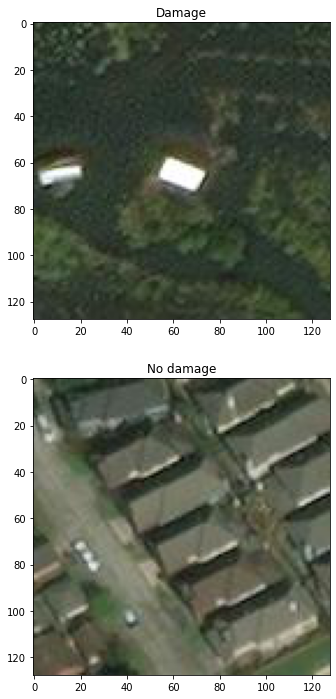

In [ ]:
# Sample images
damage_sample = imread("/content/train_another/damage/-93.65871_30.026395.jpeg")
no_damage_sample = imread("/content/train_another/no_damage/-95.6266_29.860549.jpeg")
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.imshow(damage_sample)
plt.title("Damage")
plt.subplot(212)
plt.imshow(no_damage_sample)
plt.title("No damage")
plt.show()

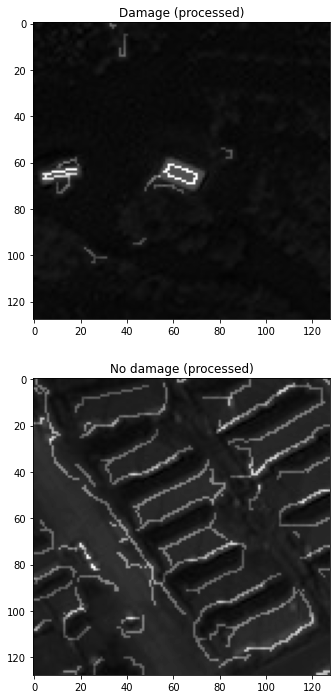

In [ ]:
# Image processing
### Step 1: Guassian blur
### Step 2: Erosion
### Step 3: Edge detection
### Step 4: Edge enhancement

# Function to enhance edges
def process(images, save_dir=None):
    processed_images = []
    for i in range(len(images)):
        # Gaussian blur
        gaussian_img = cv2.GaussianBlur(images[i], (3, 3), 1)
        # Erosion
        kernel = np.ones((3, 3), np.uint8)
        eroded_img = cv2.erode(gaussian_img, kernel, iterations=2)
        # Edge detection
        canny_img = cv2.Canny(eroded_img, 80, 120) - np.ones(shape=(128, 128))
        # Enhance edges
        processed_img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY) + 0.5*cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)*(canny_img//254)
        processed_images.append(processed_img)
        if save_dir:
            # Save processed image
            cv2.imwrite(os.path.join(save_dir, f'{i+1}.jpeg'), processed_img)
    return processed_images

damage_processed = process([damage_sample], save_dir=None)[0]
no_damage_processed = process([no_damage_sample], save_dir=None)[0]
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.imshow(damage_processed, cmap="gray")
plt.title("Damage (processed)")
plt.subplot(212)
plt.imshow(no_damage_processed, cmap="gray")
plt.title("No damage (processed)")
plt.show()

In [ ]:
train_damage = [cv2.imread(file) for file in glob.glob('/content/train_another/damage/*.jpeg')]
train_no_damage = [cv2.imread(file) for file in glob.glob('/content/train_another/no_damage/*.jpeg')]
test_damage = [cv2.imread(file) for file in glob.glob('/content/test/damage/*.jpeg')]
test_no_damage = [cv2.imread(file) for file in glob.glob('/content/test/no_damage/*.jpeg')]
val_damage = [cv2.imread(file) for file in glob.glob('/content/validation_another/damage/*.jpeg')]
val_no_damage = [cv2.imread(file) for file in glob.glob('/content/validation_another/no_damage/*.jpeg')]

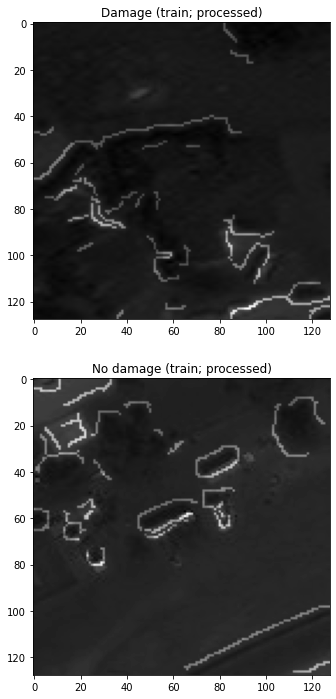

In [ ]:
os.makedirs("/content/train_proc/damage")
os.makedirs("/content/train_proc/no_damage")
train_damage_proc = process(train_damage, save_dir = "/content/train_proc/damage")
train_no_damage_proc = process(train_no_damage, save_dir="/content/train_proc/no_damage")

train_df = pd.DataFrame(columns=["image", "damage"])
train_df.image = [file for file in glob.glob('/content/train_proc/damage/*.jpeg')] + [file for file in glob.glob('/content/train_proc/no_damage/*.jpeg')]
train_df.damage = ["1"]*5000 + ["0"]*5000
train_df.reset_index(inplace=True, drop=True)

plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.imshow(train_damage_proc[10], cmap="gray")
plt.title("Damage (train; processed)")
plt.subplot(212)
plt.imshow(train_no_damage_proc[10], cmap="gray")
plt.title("No damage (train; processed)")
plt.show()

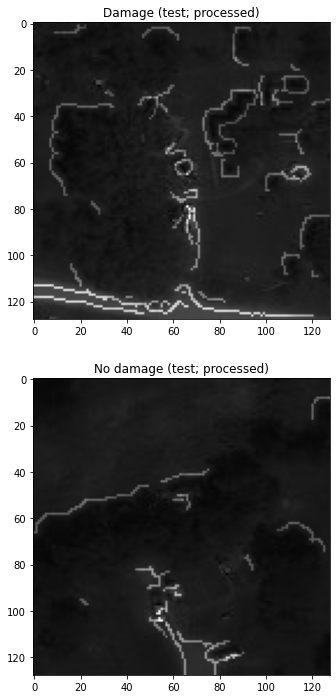

In [ ]:
os.makedirs("/content/test_proc/damage")
os.makedirs("/content/test_proc/no_damage")
test_damage_proc = process(test_damage, save_dir = "/content/test_proc/damage")
test_no_damage_proc = process(test_no_damage, save_dir = "/content/test_proc/no_damage")

test_df = pd.DataFrame(columns=["image", "damage"])
test_df.image = [file for file in glob.glob('/content/test_proc/damage/*.jpeg')] + [file for file in glob.glob('/content/test_proc/no_damage/*.jpeg')]
test_df.damage = ["1"]*1000 + ["0"]*1000
test_df.reset_index(inplace=True, drop=True)

plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.imshow(test_damage_proc[10], cmap="gray")
plt.title("Damage (test; processed)")
plt.subplot(212)
plt.imshow(test_no_damage_proc[10], cmap="gray")
plt.title("No damage (test; processed)")
plt.show()

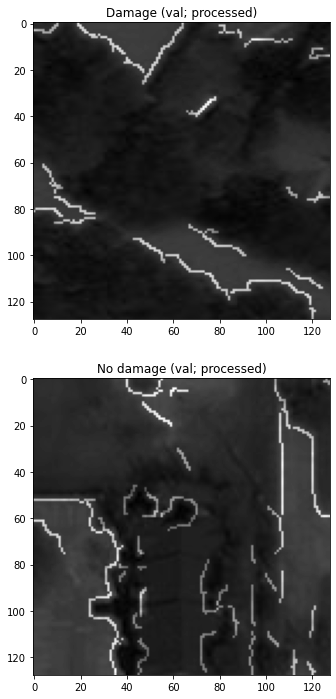

In [ ]:
os.makedirs("/content/val_proc/damage")
os.makedirs("/content/val_proc/no_damage")
val_damage_proc = process(val_damage, save_dir = "/content/val_proc/damage")
val_no_damage_proc = process(val_no_damage, save_dir = "/content/val_proc/no_damage")

val_df = pd.DataFrame(columns=["image", "damage"])
val_df.image = [file for file in glob.glob('/content/val_proc/damage/*.jpeg')] + [file for file in glob.glob('/content/val_proc/no_damage/*.jpeg')]
val_df.damage = ["1"]*1000 + ["0"]*1000
val_df.reset_index(inplace=True, drop=True)

plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.imshow(val_damage_proc[10], cmap="gray")
plt.title("Damage (val; processed)")
plt.subplot(212)
plt.imshow(val_no_damage_proc[10], cmap="gray")
plt.title("No damage (val; processed)")
plt.show()

In [ ]:
train_data_gen = ImageDataGenerator(horizontal_flip=True)
train_data = train_data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "image",
    y_col = "damage",
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode = "binary",
    shuffle = True,
    subset = "training",
    batch_size = 100
)

test_data_gen = ImageDataGenerator(horizontal_flip=True)
test_data = test_data_gen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "image",
    y_col = "damage",
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode = "binary",
    shuffle = True,
    batch_size = 100
)

val_data_gen = ImageDataGenerator(horizontal_flip=True)
val_data = val_data_gen.flow_from_dataframe(
    dataframe = val_df,
    x_col = "image",
    y_col = "damage",
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode = "binary",
    shuffle = True,
    batch_size = 100
)

Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = tf.optimizers.SGD(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      1664      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 128)     204928    
                                                                 
 batch_normalization_1 (Batc  (None, 120, 120, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                        

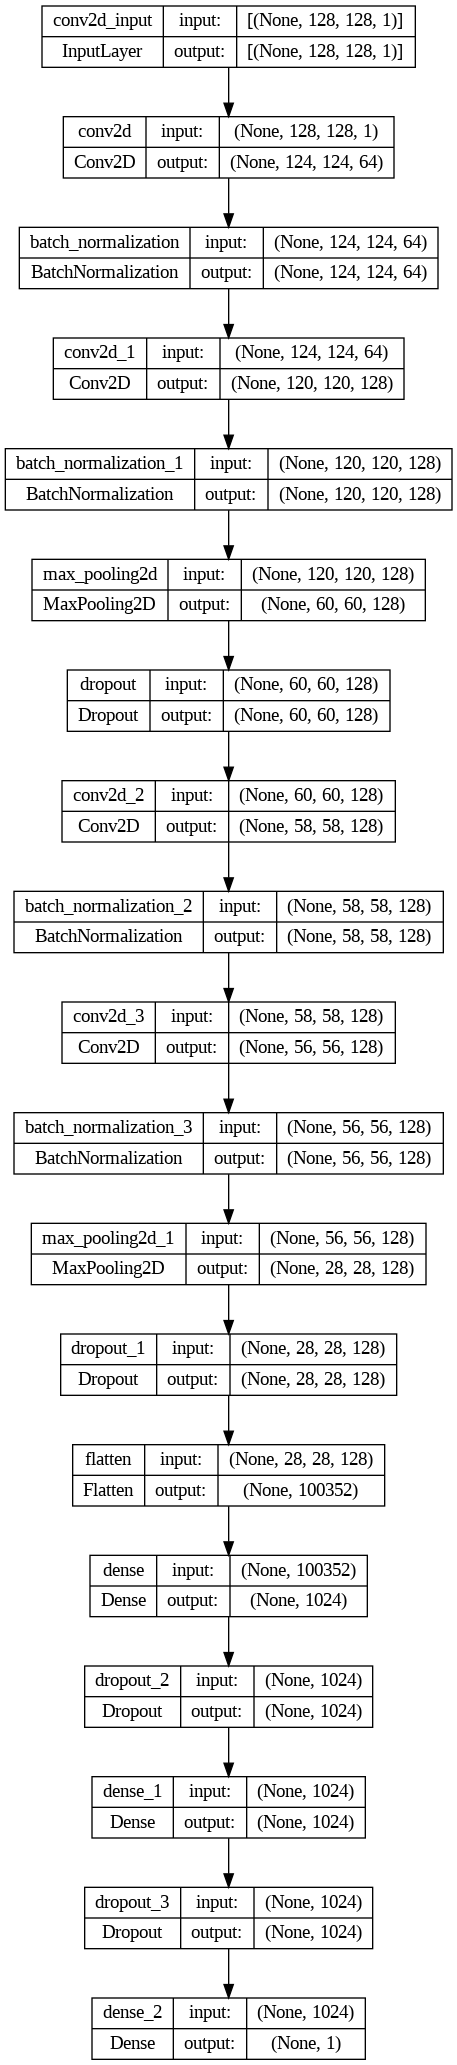

In [4]:
plot_model(model, to_file="harveynet4.png", show_shapes=True)

In [ ]:
# 21 minutes to train
history = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
100/100 [==============================] - 74s 571ms/step - loss: 0.5652 - accuracy: 0.8175 - val_loss: 0.5604 - val_accuracy: 0.6475
Epoch 2/20
100/100 [==============================] - 58s 580ms/step - loss: 0.2999 - accuracy: 0.8788 - val_loss: 0.5526 - val_accuracy: 0.7035
Epoch 3/20
100/100 [==============================] - 59s 585ms/step - loss: 0.2697 - accuracy: 0.8885 - val_loss: 0.3775 - val_accuracy: 0.8325
Epoch 4/20
100/100 [==============================] - 59s 585ms/step - loss: 0.2347 - accuracy: 0.9021 - val_loss: 0.2380 - val_accuracy: 0.9060
Epoch 5/20
100/100 [==============================] - 58s 584ms/step - loss: 0.2282 - accuracy: 0.9105 - val_loss: 0.2315 - val_accuracy: 0.8995
Epoch 6/20
100/100 [==============================] - 59s 585ms/step - loss: 0.2095 - accuracy: 0.9164 - val_loss: 0.2232 - val_accuracy: 0.9120
Epoch 7/20
100/100 [==============================] - 58s 584ms/step - loss: 0.2016 - accuracy: 0.9200 - val_loss: 0.3374 - val_ac

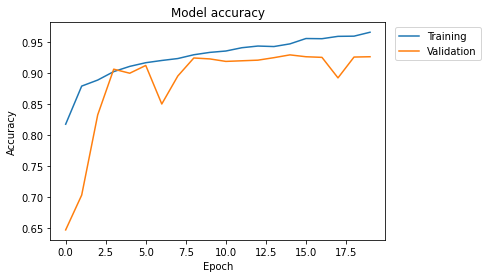

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

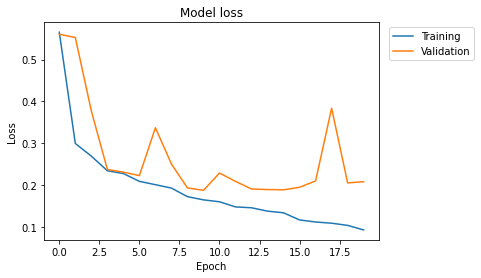

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 2s 114ms/step - loss: 0.1292 - accuracy: 0.9550


[0.129177987575531, 0.9549999833106995]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/harveynet4.h5')